# Potato Disease Detection using CNN

## 📘 Overview

This project uses Convolutional Neural Networks (CNNs) to classify potato leaf images into three categories:

Early Blight

Late Blight

Healthy

We’ll use the Potato Disease Detection dataset from Kaggle, preprocess it, train a CNN model, and evaluate its accuracy.

## 1. Import Required Libraries

In [122]:
import kagglehub
import os
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory


## 2. Load Dataset from Kaggle

In [123]:
# Download latest version
path = kagglehub.dataset_download("mgmitesh/potato-disease-detection-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'potato-disease-detection-dataset' dataset.
Path to dataset files: /kaggle/input/potato-disease-detection-dataset


## 3. Create Training and Validation Datasets



In [124]:
train_ds=image_dataset_from_directory(
    directory=path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256,256),
    batch_size=32
)
test_ds=image_dataset_from_directory(
    directory=path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256,256),
    batch_size=32
)

Found 2152 files belonging to 3 classes.
Using 1722 files for training.
Found 2152 files belonging to 3 classes.
Using 430 files for validation.


In [125]:
class_names=train_ds.class_names
n_classes=len(class_names)
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


## 4. Normalize and Optimize Datasets

In [126]:
def resize_and_rescale(image):
  image=image/255.0
  return tf.image.resize(image,(256,256))

train_ds=train_ds.map(lambda x,y: (resize_and_rescale(x),y))
test_ds=test_ds.map(lambda x,y: (resize_and_rescale(x),y))

autotune=tf.data.AUTOTUNE
train_ds=train_ds.cache().prefetch(buffer_size=autotune)
test_ds=test_ds.cache().prefetch(buffer_size=autotune)

# 5. Build CNN Model

In [127]:
model=Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)),
    MaxPooling2D((2,2)),
     Dropout(0.1),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
     Dropout(0.1),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.1),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
     Dropout(0.1),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
     Dropout(0.1),
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.3),
    Dense(64,activation='relu'),
    Dense(n_classes,activation='softmax')
])
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 6. Train the Model

In [128]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(
    monitor='loss',
    patience=5
)
history=model.fit(train_ds,epochs=40,callbacks=[early_stopping],verbose=2)

Epoch 1/40
54/54 - 18s - 325ms/step - accuracy: 0.4657 - loss: 0.9221
Epoch 2/40
54/54 - 3s - 63ms/step - accuracy: 0.6214 - loss: 0.7527
Epoch 3/40
54/54 - 5s - 94ms/step - accuracy: 0.7015 - loss: 0.6495
Epoch 4/40
54/54 - 3s - 62ms/step - accuracy: 0.8473 - loss: 0.3552
Epoch 5/40
54/54 - 3s - 63ms/step - accuracy: 0.8949 - loss: 0.2788
Epoch 6/40
54/54 - 3s - 64ms/step - accuracy: 0.9309 - loss: 0.1875
Epoch 7/40
54/54 - 3s - 63ms/step - accuracy: 0.9042 - loss: 0.2389
Epoch 8/40
54/54 - 3s - 63ms/step - accuracy: 0.9547 - loss: 0.1305
Epoch 9/40
54/54 - 3s - 64ms/step - accuracy: 0.9698 - loss: 0.0770
Epoch 10/40
54/54 - 3s - 63ms/step - accuracy: 0.9739 - loss: 0.0742
Epoch 11/40
54/54 - 3s - 63ms/step - accuracy: 0.9774 - loss: 0.0679
Epoch 12/40
54/54 - 3s - 62ms/step - accuracy: 0.9547 - loss: 0.1444
Epoch 13/40
54/54 - 3s - 63ms/step - accuracy: 0.9820 - loss: 0.0464
Epoch 14/40
54/54 - 3s - 62ms/step - accuracy: 0.9756 - loss: 0.0684
Epoch 15/40
54/54 - 3s - 62ms/step - accu

In [129]:
model.evaluate(test_ds,verbose=2)


14/14 - 2s - 112ms/step - accuracy: 0.9698 - loss: 0.1088


[0.10884460061788559, 0.9697674512863159]

## Visualize Training Performance

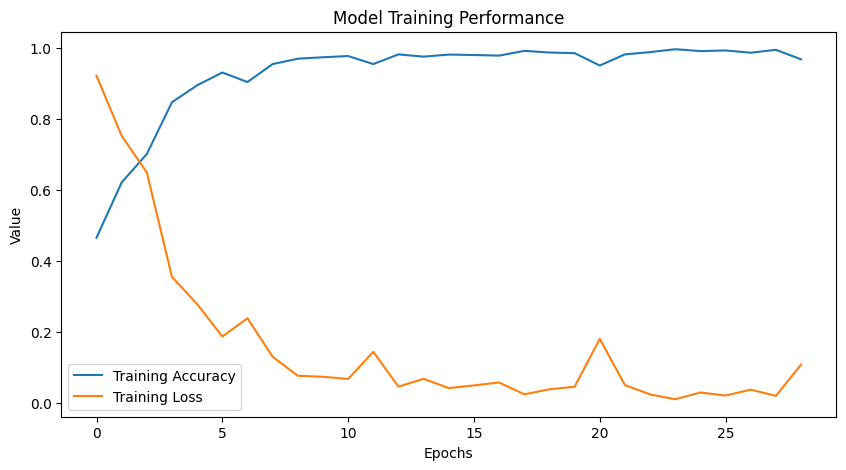

In [130]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()


## 8. Evaluate on Test Dataset

In [131]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9717 - loss: 0.1077
✅ Test Accuracy: 96.98%


## 9. Confusion Matrix & Classification Report

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


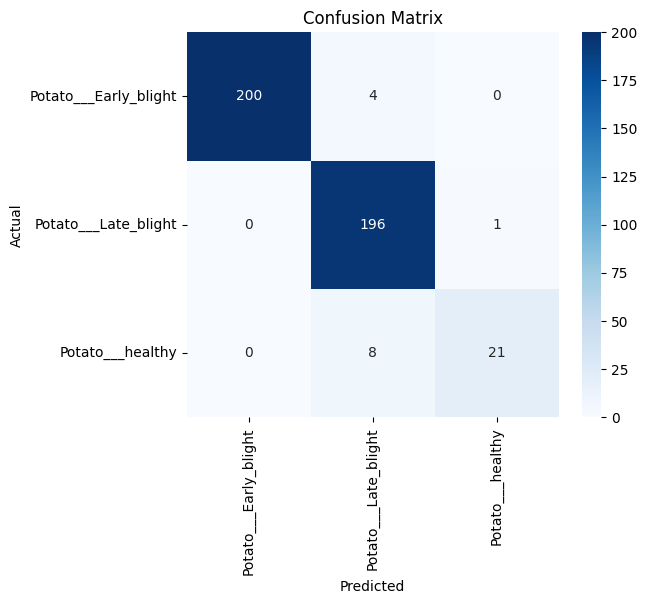


Classification Report:

                       precision    recall  f1-score   support

Potato___Early_blight       1.00      0.98      0.99       204
 Potato___Late_blight       0.94      0.99      0.97       197
     Potato___healthy       0.95      0.72      0.82        29

             accuracy                           0.97       430
            macro avg       0.97      0.90      0.93       430
         weighted avg       0.97      0.97      0.97       430



In [132]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
